<a href="https://colab.research.google.com/github/ClementineBeau/Atelier_Ionex/blob/main/notebook_atelier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python pour l’analyse des cartes TEC IONEX

Ce script Python a pour objectif de lire, traiter, décompresser, visualiser et analyser les cartes TEC (Total Electron Content) issues de fichiers IONEX. Ces cartes représentent la densité totale d’électrons dans l’ionosphère, une donnée importante pour la correction des signaux GNSS.

Ce travail s’inspire du notebook [github](https://github.com/daniestevez/jupyter_notebooks/blob/master/IONEX.ipynb).

In [7]:
#télécharge les données IONEX sur le dépot GitHub

!git clone https://github.com/ClementineBeau/Atelier_Ionex.git/

Cloning into 'Atelier_Ionex'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 47 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 26.62 MiB | 9.76 MiB/s, done.
Resolving deltas: 100% (5/5), done.



#### Periode étudiée :
La période étudiée s’étend du **1 au 17 août 2024**.
Cette plage temporelle se situe au **maximum solaire du cycle 25**, période où le rayonnement extrême ultraviolet (EUV) émis par le Soleil est élevé, favorisant une forte ionisation de l’ionosphère. Le mois d'août est également proche de l’**anomalie équinoxiale** (effet saisonnier où la géométrie Terre–Soleil maximise la production électronique), ce qui contribue à élever les valeurs de TEC observées.

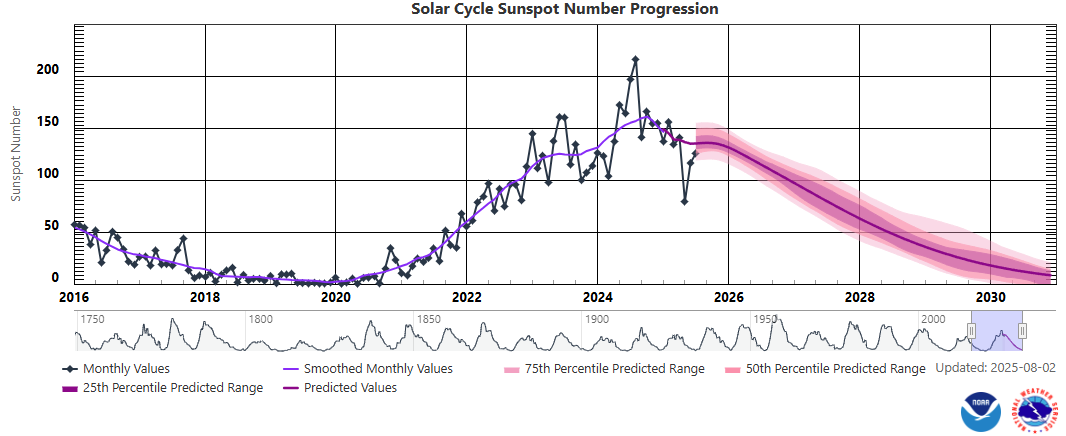

Source du graphique: https://www.swpc.noaa.gov/products/solar-cycle-progression


In [11]:
from IPython.display import Image, display
display(Image("/content/Atelier_Ionex/data/img.png"))
print('Source du graphique: https://www.swpc.noaa.gov/products/solar-cycle-progression')

##Données utilisées UQRG
Les fichiers nommés uqrg2140.24i.Z à uqrg2300.24i.Z correspondent à des **cartes ionosphériques globales** produites par le modèle **TOMION-v1**, développé par l’**Université Politècnica de Catalunya** (UPC). Ces cartes font partie du produit **UQRG (UPC Rapid Global Ionospheric Map)**, généré quotidiennement à partir de données GNSS à double fréquence.
 Chaque fichier suit la nomenclature **uqrgDDD0.YYi.Z**, où DDD est le jour julien (ici de 214 à 230), et YY l’année (2024), indiquant que les données couvrent la période du 1er août au 17 août 2024. Les cartes sont fournies au format **IONEX**, avec une résolution de 15 minutes en temps, 5° en longitude et 2,5° en latitude, et contiennent des estimations du **contenu total vertical en électrons (VTEC)**.

  Source: https://pithia-nrf.eu/pithia-nrf-developers/consortium/members/upc/infrastructure-or-equipment

  Les données ont été pré-téléchargées ici : https://cddis.nasa.gov/archive/gnss/products/ionex

## Imports

In [40]:
!pip install cartopy
!pip install unlzw3
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm, Normalize
import cartopy.crs as ccrs
from unlzw3 import unlzw
from datetime import datetime
from ipywidgets import interact, IntSlider
from IPython.display import display

## Configuration

In [28]:
plt.rcParams['figure.figsize'] = [14, 10]
FOLDER_IONEX = "/content/Atelier_Ionex/data/"
LAT_QC, LON_QC = 46.8139, -71.2082  # Coordonnées de Québec

## Fonctions

In [64]:
# === FONCTIONS DE LECTURE ===
def parse_map(tecmap, exponent=-1):
    """Extrait une carte TEC depuis un bloc de texte d’un fichier IONEX."""
    tecmap = re.split('.*END OF TEC MAP', tecmap)[0]
    return np.stack(
        [np.fromstring(l, sep=' ') for l in re.split('.*LAT/LON1/LON2/DLON/H\\n', tecmap)[1:]]
    ) * 10 ** exponent

def get_tecmaps_with_time(filename):
    """Lit un fichier IONEX et retourne une liste [(date, carte TEC), ...]."""
    with open(filename) as f:
        ionex = f.read()
    blocs = ionex.split('START OF TEC MAP')[1:]
    cartes_dates = []
    for bloc in blocs:
        date_match = re.search(r'(\d{4})\s+(\d{1,2})\s+(\d{1,2})\s+(\d{1,2})\s+(\d{1,2})\s+(\d{1,2})', bloc)
        if date_match:
            date = tuple(map(int, date_match.groups()))
        else:
            date = (0, 0, 0, 0, 0, 0)
        cartes_dates.append((date, parse_map(bloc)))
    return cartes_dates

def decompress_ionex_file(filepath):
    """Décompresse un fichier .Z si nécessaire et retourne le chemin du fichier décompressé."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Fichier non trouvé : {filepath}")
    if not filepath.lower().endswith(".z"):
        return filepath  # déjà décompressé

    filepath_out = filepath[:-2]
    if os.path.exists(filepath_out):
        return filepath_out

    with open(filepath, 'rb') as f_in:
        data = unlzw(f_in.read())
    with open(filepath_out, 'wb') as f_out:
        f_out.write(data)
    return filepath_out

def get_tec(tecmap, lat, lon):
    """Extrait la valeur TEC à une latitude et longitude données."""
    i = round((87.5 - lat) * (tecmap.shape[0] - 1) / (2 * 87.5))
    j = round((180 + lon) * (tecmap.shape[1] - 1) / 360)
    return tecmap[i, j]


# === FONCTIONS D’AFFICHAGE ===
def plot_tec_map(tecmap, ax, title="",coast=0.5):
    """Trace une carte TEC sur un axe donné."""
    ax.clear()
    ax.coastlines(linewidths=coast)
    proj = ccrs.PlateCarree()
    im = ax.imshow(
        tecmap, cmap='viridis', vmin=0, vmax=110,
        extent=(-180, 180, -87.5, 87.5), transform=proj
    )
    ax.set_title(title)
    return im

##Lecture des fichiers

In [42]:
files_ionex_Z = sorted([f for f in os.listdir(FOLDER_IONEX) if f.endswith('.Z')])
if not files_ionex_Z:
    raise RuntimeError("Aucun fichier .Z trouvé dans le dossier.")
print(files_ionex_Z) #Vérifier que les fichiers de type uqrg2xx.24i.Z apparaissent

['uqrg2140.24i.Z', 'uqrg2150.24i.Z', 'uqrg2160.24i.Z', 'uqrg2170.24i.Z', 'uqrg2180.24i.Z', 'uqrg2190.24i.Z', 'uqrg2200.24i.Z', 'uqrg2210.24i.Z', 'uqrg2220.24i.Z', 'uqrg2230.24i.Z', 'uqrg2240.24i.Z', 'uqrg2250.24i.Z', 'uqrg2260.24i.Z', 'uqrg2270.24i.Z', 'uqrg2280.24i.Z', 'uqrg2290.24i.Z', 'uqrg2300.24i.Z']


## Tracer le TEC mondial - carte glissante

In [65]:
# Exemple : utiliser le 3ᵉ fichier pour la carte glissante, vous pouvez changer : files_ionex_Z[x]
i = 15
file_example = decompress_ionex_file(os.path.join(FOLDER_IONEX, files_ionex_Z[i]))
carte_dates = get_tecmaps_with_time(file_example)

# Fonction d'affichage interactif
def afficher_carte(idx):
    date, tecmap = carte_dates[idx]
    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=proj))
    im = plot_tec_map(tecmap, ax, f"VTEC map — {date[0]}-{date[1]:02d}-{date[2]:02d} {date[3]:02d}:{date[4]:02d}")
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('TECU ($10^{16} \\mathrm{el}/\\mathrm{m}^2$)')
    plt.show()

# Slider interactif
slider = IntSlider(value=0, min=0, max=len(carte_dates)-1, step=1, description='Temps')
interact(afficher_carte, idx=slider)


interactive(children=(IntSlider(value=0, description='Temps', max=96), Output()), _dom_classes=('widget-intera…

<function __main__.afficher_carte(idx)>

## Carte fixe avec contours

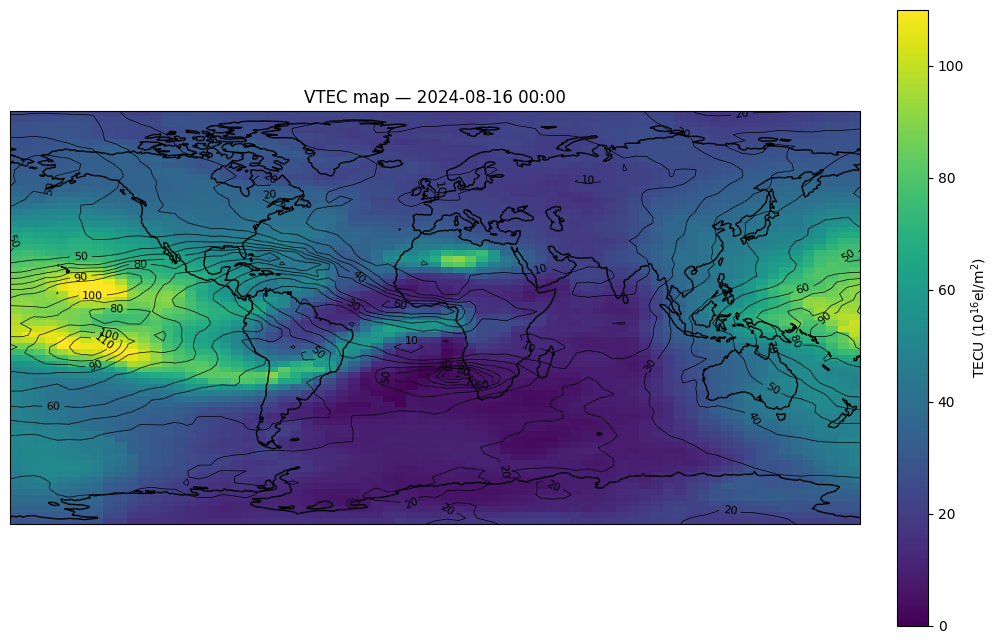

In [71]:
j = 0
fig2, ax2 = plt.subplots(subplot_kw=dict(projection=proj), figsize=(12, 8))
date_fixed, tecmap_fixed = carte_dates[j]
lons = np.linspace(-180, 180, tecmap_fixed.shape[1])
lats = np.linspace(-87.5, 87.5, tecmap_fixed.shape[0])
lon_grid, lat_grid = np.meshgrid(lons, lats)
im2 = plot_tec_map(tecmap_fixed, ax2
                   ,f"VTEC map — {date_fixed[0]}-{date_fixed[1]:02d}-{date_fixed[2]:02d} {date_fixed[3]:02d}:{date_fixed[4]:02d}"
                  ,coast=1)
levels = np.arange(0, 121, 10)
contour = ax2.contour(lon_grid, lat_grid, tecmap_fixed, levels=levels,
                      colors='black', linewidths=0.5, transform=proj)
ax2.clabel(contour, inline=True, fontsize=8, fmt='%d')
cbar2 = fig2.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label('TECU ($10^{16} \\mathrm{el}/\\mathrm{m}^2$)')


## Moyenne Journalière du TEC à Québec

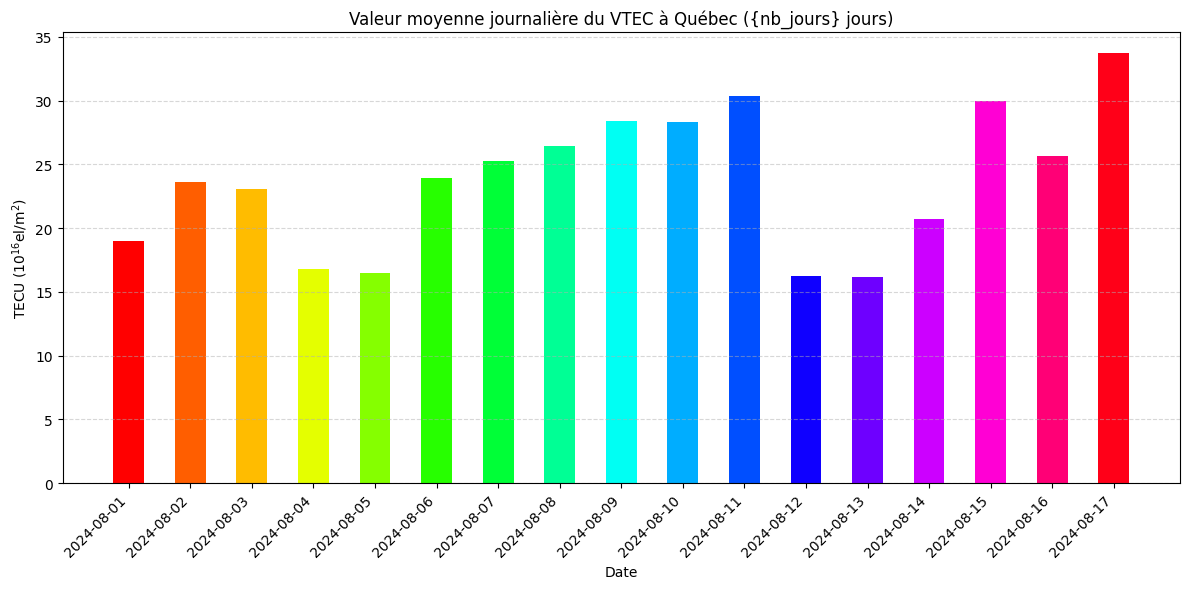

In [78]:
moyennes, dates_fmt, couleurs = [], [], []
for day_idx, file in enumerate(files_ionex_Z):
    file_i = decompress_ionex_file(os.path.join(FOLDER_IONEX, file))
    cartes_jour = get_tecmaps_with_time(file_i)
    if cartes_jour:
        date0 = cartes_jour[0][0]
        date_obj = datetime(*date0[:3])
        dates_fmt.append(date_obj.strftime("%Y-%m-%d"))
        valeurs = [get_tec(tecmap, LAT_QC, LON_QC) for _, tecmap in cartes_jour]
        moyennes.append(np.mean(valeurs))
        couleurs.append(cmap_days(day_idx))

fig4, ax4 = plt.subplots(figsize=(12, 6))
ax4.bar(dates_fmt, moyennes, color=couleurs, width=0.5)
ax4.set_title("Variation moyenne journalière du VTEC à Québec ({nb_jours} jours)")
ax4.set_xlabel("Date")
ax4.set_ylabel('TECU ($10^{16} \\mathrm{{el}}/\\mathrm{{m}}^2$)')
ax4.set_xticks(dates_fmt)
ax4.set_xticklabels(dates_fmt, rotation=45, ha='right')
ax4.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


##Variations journalières du TEC à Québec

/tmp/ipython-input-2750030333.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_days = plt.cm.get_cmap('hsv', nb_jours)


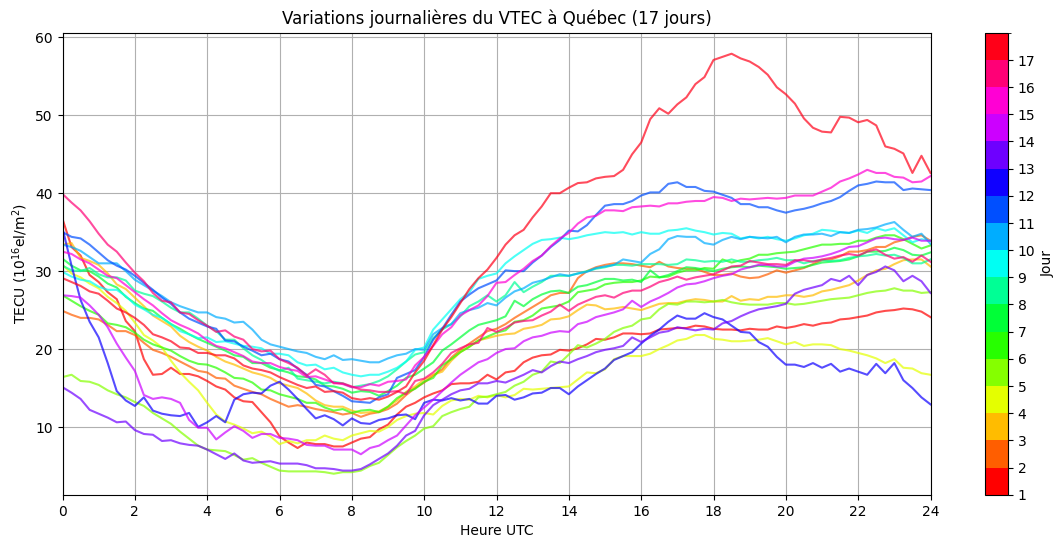

In [79]:
nb_jours = len(files_ionex_Z)
cmap_days = plt.cm.get_cmap('hsv', nb_jours)
norm_days = BoundaryNorm(np.arange(1, nb_jours + 2), ncolors=nb_jours)
sm = ScalarMappable(norm=norm_days, cmap=cmap_days)

fig3, ax3 = plt.subplots(figsize=(14, 6))
for day_idx, file in enumerate(files_ionex_Z, start=1):
    file_i = decompress_ionex_file(os.path.join(FOLDER_IONEX, file))
    cartes_jour = get_tecmaps_with_time(file_i)
    data_points = [(date[3] + date[4] / 60.0, get_tec(tecmap, LAT_QC, LON_QC)) for date, tecmap in cartes_jour]
    data_points.sort()
    heures, tec_values = zip(*data_points)
    ax3.plot(heures, tec_values, color=cmap_days(day_idx - 1), alpha=0.7, label=f'Jour {day_idx}')

ax3.set_title(f'Variations journalières du VTEC à Québec ({nb_jours} jours)')
ax3.set_xlabel('Heure UTC')
ax3.set_ylabel('TECU ($10^{16} \\mathrm{{el}}/\\mathrm{{m}}^2$)')
ax3.grid(True)
ax3.set_xlim(0, 24)
ax3.set_xticks(np.arange(0, 25, 2))
fig3.colorbar(sm, ax=ax3, orientation='vertical', ticks=np.arange(1, nb_jours + 1), label='Jour')

